# Capstone 2 -- Preprocessing and Training Data Development
**[Online Retail II](https://archive.ics.uci.edu/dataset/502/online+retail+ii)**

## Imports and Defaults

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

**Set Default Preferences**

In [2]:
# display all columns
pd.set_option('display.max_columns', None)

# surpress scientific notation
pd.options.display.float_format = '{:}'.format

**Import Data** 

'rfm' datafram is the main df for models. It includes Recency, Frequency, and Monetary calculations from the has_id df which represents known customers.

In [3]:
# import rfm df
path = '../Data/rfm.csv'
rfm = pd.read_csv(path)

In [4]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5878 entries, 0 to 5877
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5878 non-null   float64
 1   Recency      5878 non-null   int64  
 2   Frequency    5878 non-null   int64  
 3   Monetary     5878 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 183.8 KB


Reload rfm with correct dtype

In [5]:
# Reload rfm with correct dtype
path = '../Data/rfm.csv'
dtype_dict= {'Recency': 'int32',
               'Frequency': 'int32',
               'Monetary': 'float32'}
rfm = pd.read_csv(path, dtype= dtype_dict, index_col='Customer ID')

In [6]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    5878 non-null   int32  
 1   Frequency  5878 non-null   int32  
 2   Monetary   5878 non-null   float32
dtypes: float32(1), int32(2)
memory usage: 114.8 KB


In [7]:
rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.0,326,12,77556.4609375
12347.0,2,8,4921.52978515625
12348.0,75,5,2019.4000244140625
12349.0,19,4,4428.68994140625
12350.0,310,1,334.3999938964844


'has_id' is the base information and is needed for additional feature engineering.

In [8]:
path2 = '../Data/has_id.csv'
has_id = pd.read_csv(path2)
has_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779425 entries, 0 to 779424
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      779425 non-null  int64  
 1   StockCode    779425 non-null  object 
 2   Description  779425 non-null  object 
 3   Quantity     779425 non-null  int64  
 4   InvoiceDate  779425 non-null  object 
 5   Price        779425 non-null  float64
 6   Customer ID  779425 non-null  float64
 7   Country      779425 non-null  object 
 8   Sales        779425 non-null  float64
dtypes: float64(3), int64(2), object(4)
memory usage: 53.5+ MB


In [9]:
# Reload with correct dtype
dtype_dict2 = {'Invoice':'string',
              'StockCode':'string',
              'Description':'string',
              'Quantity':'int32',
              'Price':'float32',
              'Customer ID':'string',
              'Country':'string',
              'Sales':'float32'}

has_id = pd.read_csv(path2, dtype=dtype_dict2, parse_dates=['InvoiceDate'])
has_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779425 entries, 0 to 779424
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      779425 non-null  string        
 1   StockCode    779425 non-null  string        
 2   Description  779425 non-null  string        
 3   Quantity     779425 non-null  int32         
 4   InvoiceDate  779425 non-null  datetime64[ns]
 5   Price        779425 non-null  float32       
 6   Customer ID  779425 non-null  string        
 7   Country      779425 non-null  string        
 8   Sales        779425 non-null  float32       
dtypes: datetime64[ns](1), float32(2), int32(1), string(5)
memory usage: 44.6 MB


## Model 1: RFM only

### Model 1: Train Test Split
Before normalizing and standardizing the data it will be split into a training set and a test set with a 80/20 split.

In [10]:
rfm_train, rfm_test = train_test_split(rfm, test_size=0.2, random_state=25)

### Model 1: Pre Processing - Transform and Scale
Due to the highly skewed nature of the data and the different magnitudes of the data, the train and test sets will be transformed and standardized. Power Transformer will be used to transform the data to deal with the skewness. Standard Scaler will be used to standardized the data to deal with differences in magnitude.

In [11]:
# Transform Train data
power_transformer = PowerTransformer(method='box-cox')
rfm_train_transformed = power_transformer.fit_transform(rfm_train)

# Scale Train data
scaler = StandardScaler()
rfm_train_scaled = scaler.fit_transform(rfm_train_transformed)

In [12]:
# Transform test data
rfm_test_transformed = power_transformer.transform(rfm_test)

# Scale test data
rfm_test_scaled = scaler.fit_transform(rfm_test_transformed)

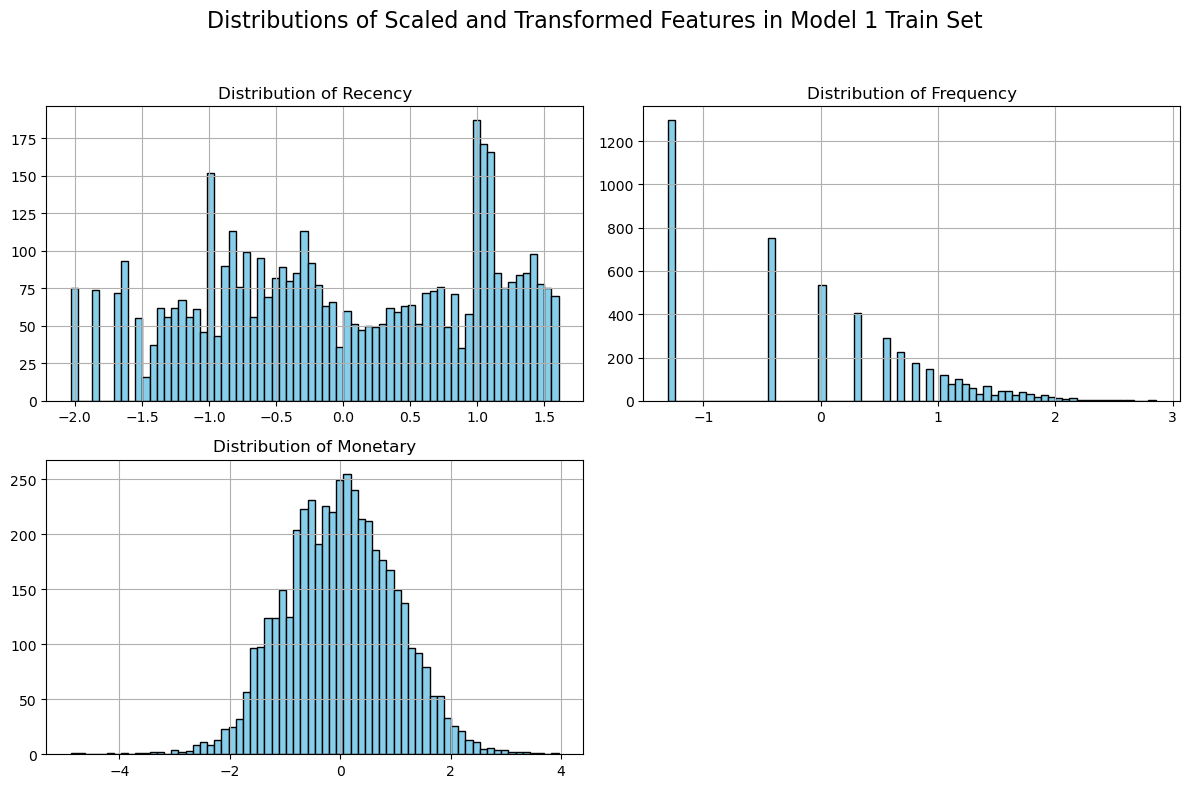

In [13]:
# Example: Creating the DataFrame to view trqnsformes and scaled data
scaled_transformed_train_df = pd.DataFrame(rfm_train_scaled, columns=['Recency', 'Frequency', 'Monetary'])

# Plot histograms
axes = scaled_transformed_train_df.hist(
    bins=int(np.sqrt(len(scaled_transformed_train_df))), 
    figsize=(12, 8), 
    color='skyblue', 
    edgecolor='black'
)

# Add an overall title to the figure
plt.suptitle('Distributions of Scaled and Transformed Features in Model 1 Train Set', fontsize=16)

# Optional: Add individual titles for each subplot
for ax, column in zip(axes.flatten(), scaled_transformed_train_df.columns):
    ax.set_title(f'Distribution of {column}')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()


While the distributions are not perfectly normal thay are way less skewed and they are standardized.

## Model 2: RFM w/ Expanded Features
Model two will expand on the RFM model and add additional features including Average Order Value, customer lifetime, and Customer Lifetime Value.

### Feature Engineering

In [14]:
rfm.columns

Index(['Recency', 'Frequency', 'Monetary'], dtype='object')

In [15]:
#Copy rfm to form new df for added features
rfm_expanded = rfm.copy(deep=True)

**Average Order Value** give insight into the size of average orders.

In [16]:
# calculate Average Order Value (aov)
rfm_expanded['AOV'] = rfm.Monetary / rfm.Frequency
rfm_expanded

,Recency,Frequency,Monetary,AOV
Customer ID,,,,
12346.0,326,12,77556.4609375,6463.038411458333
12347.0,2,8,4921.52978515625,615.1912231445312
12348.0,75,5,2019.4000244140625,403.8800048828125
12349.0,19,4,4428.68994140625,1107.1724853515625
12350.0,310,1,334.3999938964844,334.3999938964844
...,...,...,...,...
18283.0,4,22,2664.89990234375,121.13181374289773
18284.0,432,1,461.67999267578125,461.67999267578125
18285.0,661,1,427.0,427.0


In [17]:
rfm_expanded.AOV.describe()

count               5878.0
mean    385.18084076162313
std     1214.2864588587054
min      2.950000047683716
25%      176.6825065612793
50%     279.24268886021207
75%     414.90245351070115
max               84236.25
Name: AOV, dtype: float64

**Customer Lifespan (lifespan)** gives insight into the length of time the customer has been purchasing from the company.  Customers with longer lifespans will in theory have higher total Monetary values. This can help distinguish between customers who are recent big spenders customers who have long lifespan and therefor have a higher Monetary Value.  Additionally it give insight into length of time buying from the company.
<br><br>
The rfm dataframe was created from the has_id dataframe in a previous step but it does not have 'InvoiceDate' which is needed to calculate lifespan.  'has_id' will be used to create the new lifespan value.

In [18]:
# create lifespan from latest purchase - earliest purchase
rfm_expanded['Lifespan'] = (has_id.groupby('Customer ID')['InvoiceDate'].transform('max') - has_id.groupby('Customer ID')['InvoiceDate'].transform('min')).dt.days
rfm_expanded

,Recency,Frequency,Monetary,AOV,Lifespan
Customer ID,,,,,
12346.0,326,12,77556.4609375,6463.038411458333,735
12347.0,2,8,4921.52978515625,615.1912231445312,735
12348.0,75,5,2019.4000244140625,403.8800048828125,735
12349.0,19,4,4428.68994140625,1107.1724853515625,735
12350.0,310,1,334.3999938964844,334.3999938964844,735
...,...,...,...,...,...
18283.0,4,22,2664.89990234375,121.13181374289773,716
18284.0,432,1,461.67999267578125,461.67999267578125,716
18285.0,661,1,427.0,427.0,716


In [19]:
rfm_expanded.Lifespan.describe()

count               5878.0
mean     573.0161619598503
std     230.80494836549343
min                    0.0
25%                  429.0
50%                  705.0
75%                  724.0
max                  738.0
Name: Lifespan, dtype: float64

**Customer Lifetime Value (CLV)** gives better insight into customer segmentation than RFM alone.  Customers can have similar RFM but very different CLV.  Adding CLV allows the company to focus on the value the customer adds.  It also allows the company to market to different types of customers.

In [20]:
# Calculate CLV
rfm_expanded['CLV'] = rfm_expanded.AOV * rfm.Frequency * rfm_expanded.Lifespan
rfm_expanded

,Recency,Frequency,Monetary,AOV,Lifespan,CLV
Customer ID,,,,,,
12346.0,326,12,77556.4609375,6463.038411458333,735,57003998.7890625
12347.0,2,8,4921.52978515625,615.1912231445312,735,3617324.3920898438
12348.0,75,5,2019.4000244140625,403.8800048828125,735,1484259.017944336
12349.0,19,4,4428.68994140625,1107.1724853515625,735,3255087.1069335938
12350.0,310,1,334.3999938964844,334.3999938964844,735,245783.99551391602
...,...,...,...,...,...,...
18283.0,4,22,2664.89990234375,121.13181374289773,716,1908068.330078125
18284.0,432,1,461.67999267578125,461.67999267578125,716,330562.8747558594
18285.0,661,1,427.0,427.0,716,305732.0


In [21]:
rfm_expanded.CLV.describe()

count               5878.0
mean    1699351.8684142341
std        9701266.4867665
min                    0.0
25%      148585.2219467163
50%     434309.45837402344
75%      1236315.367767334
max           415986736.75
Name: CLV, dtype: float64

### Model 2: Train Test Split
Model 2 will be split in the same 80/20 train/test split as with model 1.

In [22]:
rfm_expanded_train, rfm_expanded_test = train_test_split(rfm_expanded, test_size =0.2, random_state=25)

In [23]:
rfm_expanded_train

,Recency,Frequency,Monetary,AOV,Lifespan,CLV
Customer ID,,,,,,
16952.0,109,5,795.8300170898438,159.16600341796874,0,0.0
14629.0,4,2,955.260009765625,477.6300048828125,720,687787.20703125
16866.0,141,3,207.739990234375,69.24666341145833,181,37600.938232421875
15206.0,10,4,420.3000183105469,105.07500457763672,728,305978.4133300781
15422.0,323,7,1619.969970703125,231.42428152901786,713,1155038.5891113281
...,...,...,...,...,...,...
12602.0,59,1,153.1199951171875,153.1199951171875,316,48385.91845703125
15310.0,479,1,1634.6400146484375,1634.6400146484375,108,176541.12158203125
14560.0,7,44,6114.02978515625,138.95522238991478,691,4224794.581542969


### Model 2: Pre Processing - Transform and Scale
As like above Power Transformer will be used to handle the skewness and Standard Scaler will be used for standardization.

In [24]:
# Transform Model 2 Train Data
transformer2 = PowerTransformer()
rfm_expanded_train_transformed = transformer2.fit_transform(rfm_expanded_train)

In [25]:
# Scale Model 2 Train Data
scaler2=StandardScaler()
rfm_expanded_train_scaled = scaler2.fit_transform(rfm_expanded_train_transformed)

In [26]:
# Transform Model 2 Test Data
rfm_expanded_test_transformed = transformer2.transform(rfm_expanded_test)

# Scale Model 2 Test Data
rfm_expanded_test_scaled = scaler2.transform(rfm_expanded_test_transformed)

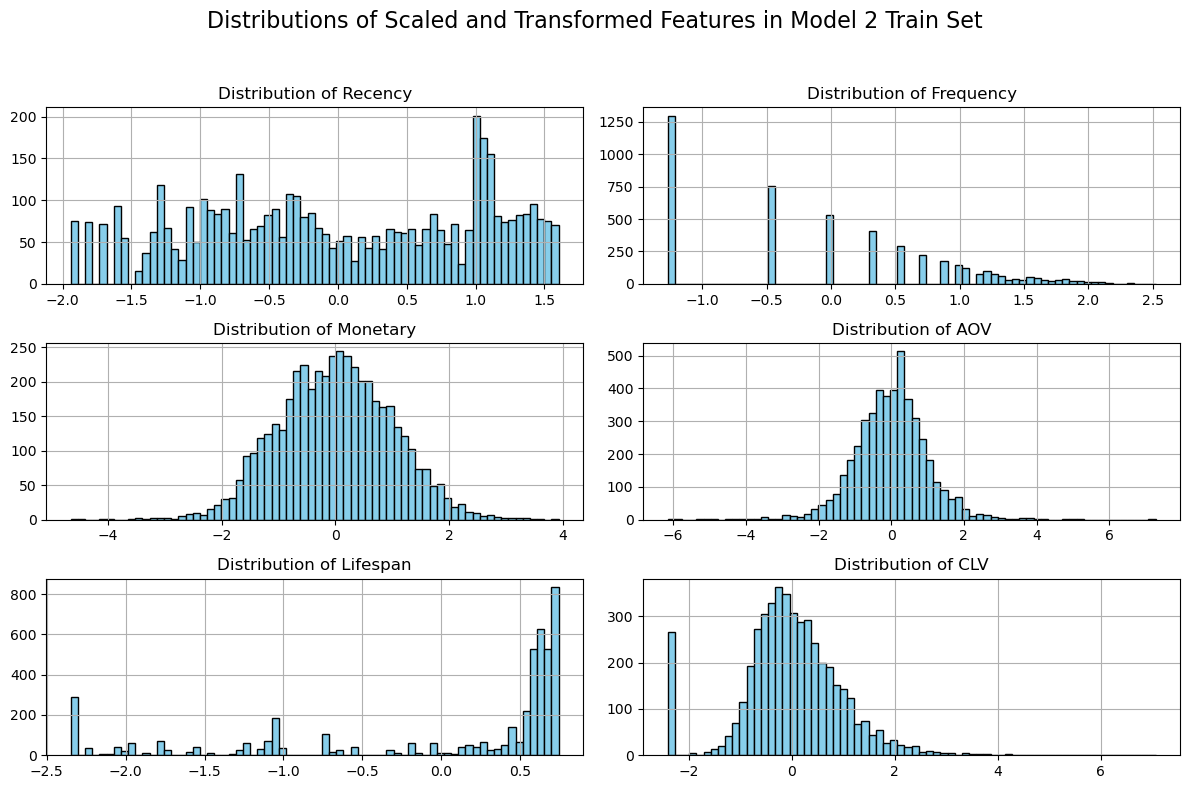

In [27]:
# Example: Creating the DataFrame to view transformes and scaled data
scaled_transformed_train_df2 = pd.DataFrame(rfm_expanded_train_scaled, columns=['Recency', 'Frequency', 'Monetary', 'AOV', 'Lifespan', 'CLV'])

# Plot histograms
axes = scaled_transformed_train_df2.hist(
    bins=int(np.sqrt(len(scaled_transformed_train_df2))), 
    figsize=(12, 8), 
    color='skyblue', 
    edgecolor='black'
)

# Add an overall title to the figure
plt.suptitle('Distributions of Scaled and Transformed Features in Model 2 Train Set', fontsize=16)

# Optional: Add individual titles for each subplot
for ax, column in zip(axes.flatten(), scaled_transformed_train_df2.columns):
    ax.set_title(f'Distribution of {column}')

plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to fit the suptitle
plt.show()

## Export Datasets

In [28]:
# rfm.columns
rfm_expanded.columns

Index(['Recency', 'Frequency', 'Monetary', 'AOV', 'Lifespan', 'CLV'], dtype='object')

Convert 

In [31]:
# export expanded rfm df
rfm_expanded.to_csv('../Data/rfm_expanded.csv', index = True)

# Convert Model 1 arrays to DF
rfm_train_scaled_df = pd.DataFrame(rfm_train_scaled, columns=list(rfm_train.columns), index=rfm_train.index)
rfm_test_scaled_df = pd.DataFrame(rfm_test_scaled, columns=list(rfm_test.columns), index=rfm_test.index)

# Export Model 1 train/test data
rfm_train_scaled_df.to_csv('../Data/rfm_train_scaled_df.csv', index = True)
rfm_test_scaled_df.to_csv('../Data/rfm_test_scaled_df.csv', index = True)

# Convert Model 2 arrays to DF
rfm_expanded_train_scaled_df = pd.DataFrame(rfm_expanded_train_scaled, columns=list(rfm_expanded_train.columns), index=rfm_expanded_train.index)
rfm_expanded_test_scaled_df = pd.DataFrame(rfm_expanded_test_scaled, columns=list(rfm_expanded_test.columns), index=rfm_expanded_test.index)

# Export Model 2 train/test data
rfm_expanded_train_scaled_df.to_csv('../Data/rfm_expanded_train_scaled_df.csv', index = True)
rfm_expanded_test_scaled_df.to_csv('../Data/rfm_expanded_test_scaled_df.csv', index = True)


In [30]:
# rfm_train_scaled_df
# rfm_test_scaled_df
# rfm_expanded_train_scaled_df
# rfm_expanded_test_scaled_df